In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import modelutils_v2 as modelutils
import copy

cmap = mpl.cm.get_cmap('viridis')

In [2]:
npeople = 100
tsteps = 21
ax=None
ntrials = 10
action = None
nlocations = 10
ntests=[int(x) for x in np.linspace(0,npeople,21)]


homelocs = np.zeros([nlocations,npeople])
for person_idx in range(npeople):
    homelocs[np.random.choice(np.arange(nlocations)),person_idx]=1.

init_state = modelutils.state(homelocs,) 

In [3]:
actions = [init_state.random_action(x) for x in ntests]


tseries_list = []

for _ in range(ntrials):
    #print('Trial: ',_,end='\r')
    state_tseries = [[copy.deepcopy(init_state)] for _ in range(len(ntests))]

    for time_idx in range(tsteps-1):
        print('Trial: ',_,'/ Time: ',time_idx,end='\r')
                     
        for test_idx in range(len(ntests)):
            state_tseries[test_idx].append(state_tseries[test_idx][-1].update_state(actions[test_idx]))

        
        actions = [state_tseries[x][-1].random_action(ntests[x]) for x in range(len(ntests))]

        
       
    tseries_list.append([modelutils.gen_plotmat(state_tseries[x]) for x in range(len(ntests))])

    
tseries_list = list(map(list, zip(*tseries_list)))  # we need to "transpose" the list of lists...I did the collection stupidly

In [4]:
percentiles = [modelutils.gen_percentiles(tseries_list[x]) for x in range(len(ntests))]
# #percentiles is a ntests long list of 6xntimepointsx5 array describing the confidence intervals for plotting

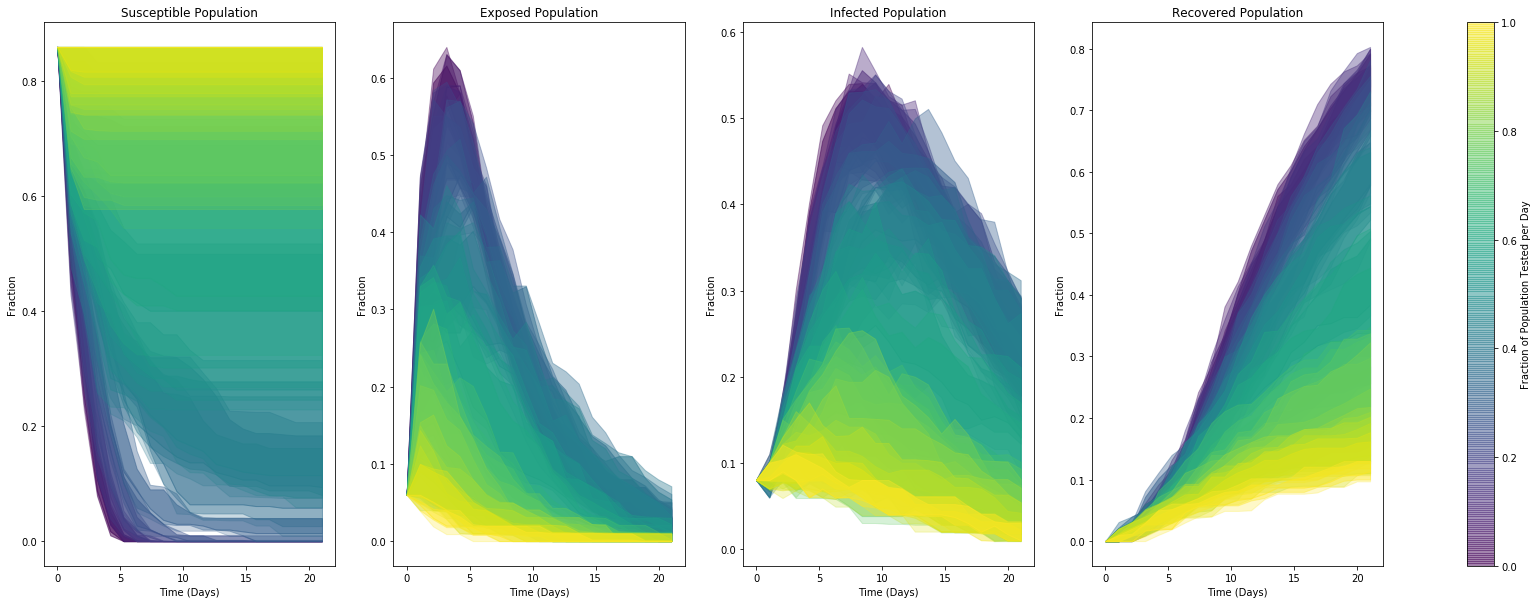

In [11]:
fig,ax = plt.subplots(figsize=(30,10),ncols=4)

xax = np.linspace(0,tsteps,tsteps)
colorarray = np.linspace(0,1,len(ntests))
alphalist = np.linspace(0.25,0.5,3)

for ax_idx in range(4):
    #going left to right, starting with susceptible
    ax[ax_idx].set_xlabel('Time (Days)')
    ax[ax_idx].set_ylabel('Fraction')
    for test_idx in range(len(ntests)):
        current_percentiles = percentiles[test_idx]
        for conf_idx in range(3):
            pcm=ax[ax_idx].fill_between(xax,
                                    current_percentiles[conf_idx,:,ax_idx]/npeople,
                                    current_percentiles[conf_idx+2,:,ax_idx]/npeople,
                                    color=cmap(colorarray[test_idx]),
                                    alpha=alphalist[conf_idx])
            
ax[0].set_title('Susceptible Population')
ax[1].set_title('Exposed Population')
ax[2].set_title('Infected Population')
ax[3].set_title('Recovered Population')

cbar = fig.colorbar(pcm,
                    ax=ax[:],
                    label='Fraction of Population Tested per Day',)  
plt.savefig('random_policy_fig.png')